# Clasificación de Dígitos Manuscritos Europeos

El reconocimiento automático de dígitos manuscritos es fundamental en aplicaciones como la digitalización de documentos, sistemas bancarios y corrección automática de exámenes. A diferencia del popular MNIST, este dataset contiene dígitos en notación europea (suiza), lo que presenta nuevos retos para los modelos clásicos.

**Fuente del dataset:**  
[Kaggle - Handwritten Digits 0-9 (European)](https://www.kaggle.com/datasets/olafkrastovski/handwritten-digits-0-9)

- Imágenes: ~21,600
- Tamaño: 90x140 px, color (.jpg)
- Clases: 0-9 (carpetas separadas)

**Objetivo:**  
Comparar el desempeño de modelos clásicos de clasificación sobre dígitos manuscritos europeos, utilizando técnicas de preprocesamiento y ajuste de hiperparámetros.

In [4]:
# Básicos
import numpy as np
import pandas as pd
import os

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento y PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Métricas
from sklearn.metrics import accuracy_score, classification_report

# Utilidades
from skimage.io import imread
from skimage.color import rgb2gray
from tqdm import tqdm
import warnings

In [6]:
base_path = 'archive'
image_paths = []
labels = []

for digit in os.listdir(base_path):
    digit_path = os.path.join(base_path, digit)
    if os.path.isdir(digit_path):
        for img_file in os.listdir(digit_path):
            if img_file.endswith('.jpg'):
                image_paths.append(os.path.join(digit_path, img_file))
                labels.append(int(digit))

print(f"Total de imágenes cargadas: {len(image_paths)}")

Total de imágenes cargadas: 21555


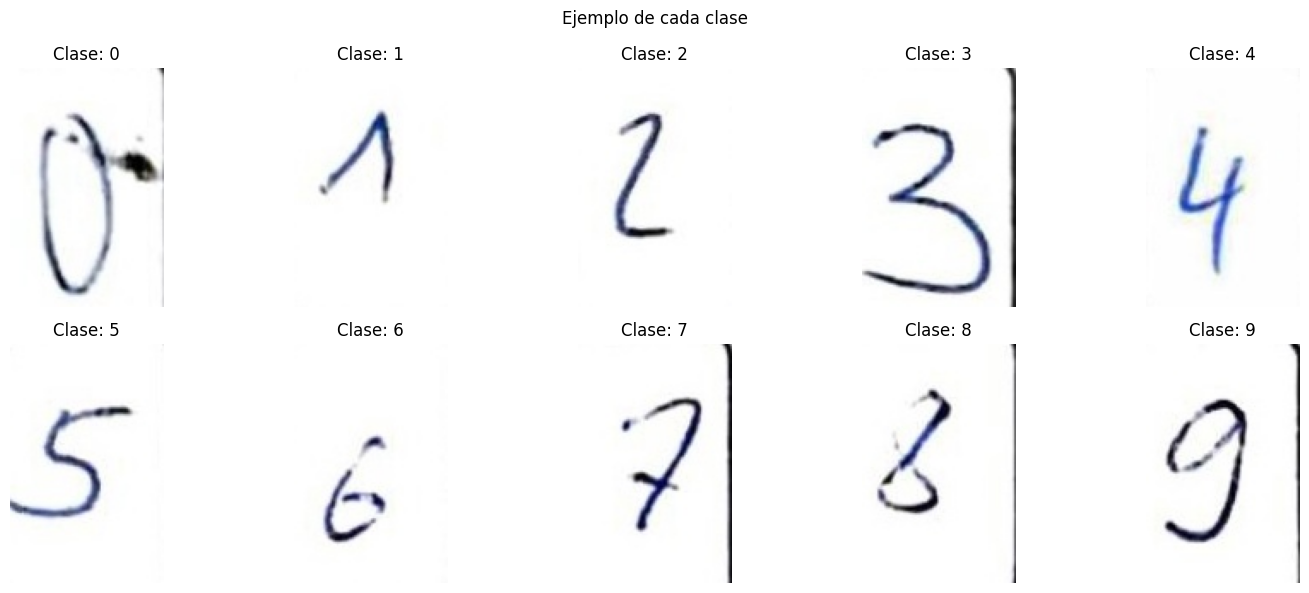

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, digit in zip(axes.flat, sorted(set(labels))):
    idx = labels.index(digit)
    img = imread(image_paths[idx])
    ax.imshow(img)
    ax.set_title(f"Clase: {digit}")
    ax.axis('off')
plt.suptitle("Ejemplo de cada clase")
plt.tight_layout()
plt.show()

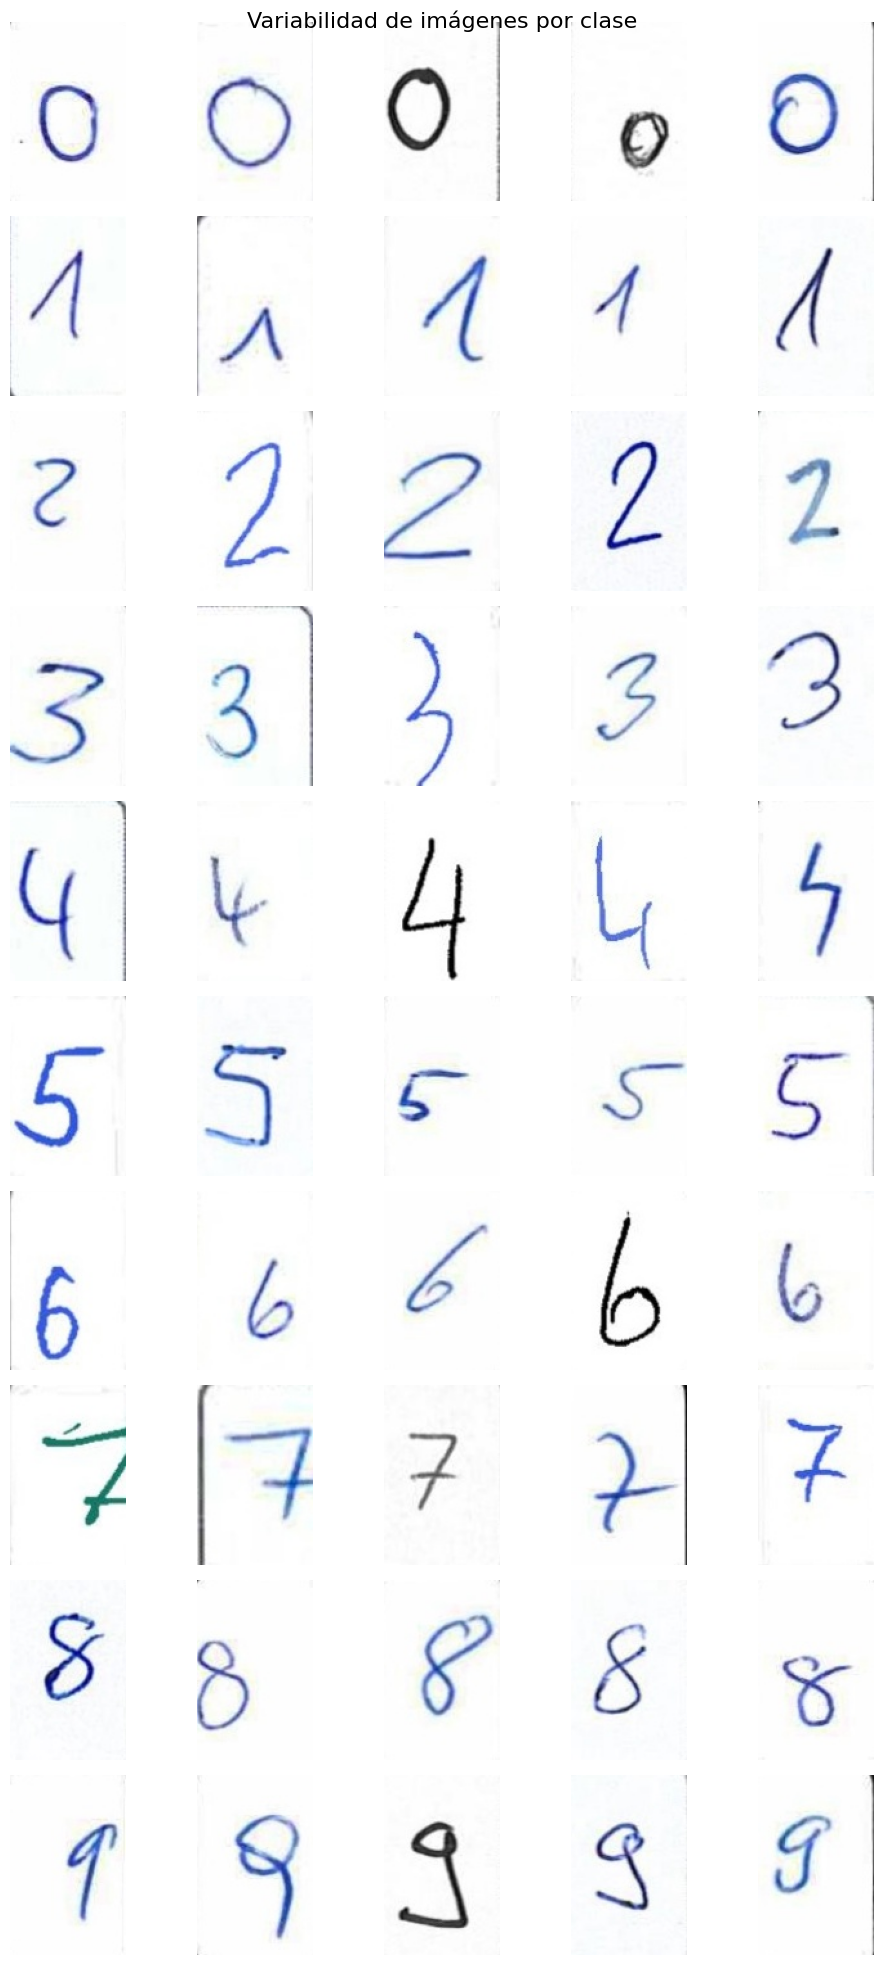

In [28]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20))
for digit in range(10):
    idxs = [i for i, label in enumerate(labels) if label == digit]
    muestras = np.random.choice(idxs, 5, replace=False)
    for j, idx in enumerate(muestras):
        img = imread(image_paths[idx])
        axes[digit, j].imshow(img, cmap='gray')
        axes[digit, j].axis('off')
        if j == 0:
            axes[digit, j].set_ylabel(f'Clase {digit}', fontsize=12)
plt.suptitle("Variabilidad de imágenes por clase", fontsize=16)
plt.tight_layout()
plt.show()

La gráfica anterior muestra un ejemplo visual de cada dígito manuscrito, permitiendo observar la variabilidad y el estilo europeo. La siguiente gráfica muestra la distribución de imágenes por clase, que es bastante balanceada.

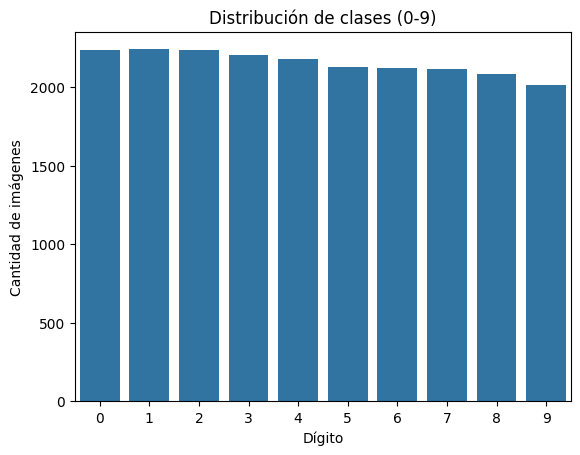

In [8]:
sns.countplot(x=labels)
plt.title('Distribución de clases (0-9)')
plt.xlabel('Dígito')
plt.ylabel('Cantidad de imágenes')
plt.show()

In [9]:
from skimage.filters import threshold_otsu

X = []
for path in tqdm(image_paths):
    img = imread(path)
    img_gray = rgb2gray(img)
    thresh = threshold_otsu(img_gray)
    img_bin = (img_gray > thresh).astype(float)
    X.append(img_bin.flatten())

100%|██████████| 21555/21555 [05:04<00:00, 70.76it/s]


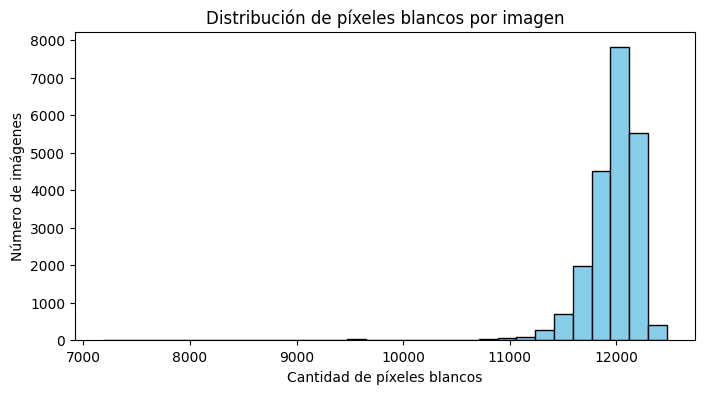

In [25]:
pixeles_blancos = [img.sum() for img in X]
plt.figure(figsize=(8,4))
plt.hist(pixeles_blancos, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de píxeles blancos por imagen')
plt.xlabel('Cantidad de píxeles blancos')
plt.ylabel('Número de imágenes')
plt.show()

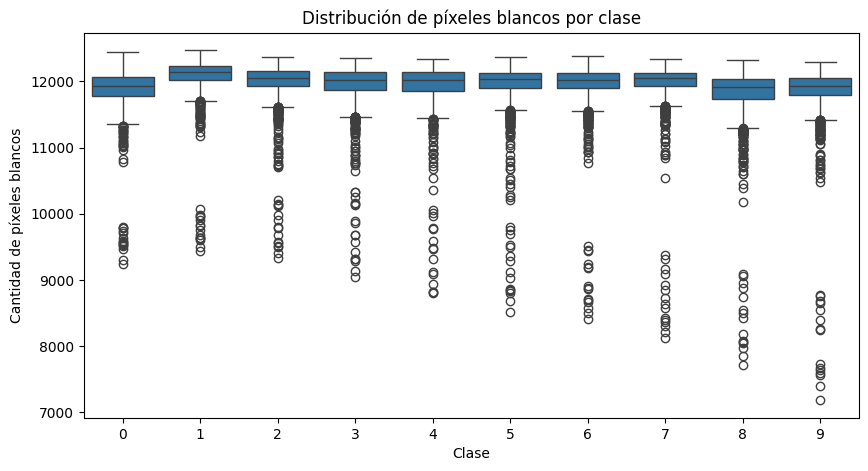

In [26]:
df_pixeles = pd.DataFrame({'Clase': labels, 'PixelesBlancos': pixeles_blancos})
plt.figure(figsize=(10,5))
sns.boxplot(x='Clase', y='PixelesBlancos', data=df_pixeles)
plt.title('Distribución de píxeles blancos por clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de píxeles blancos')
plt.show()

In [10]:
from skimage.transform import resize

X = []
for path in tqdm(image_paths):
    img = imread(path)
    img_gray = rgb2gray(img)
    X.append(img_gray.flatten())

X = np.array(X)
y = np.array(labels)
print("Dimensión de cada imagen:", X.shape[1])

100%|██████████| 21555/21555 [02:04<00:00, 173.58it/s]


Dimensión de cada imagen: 12600


In [11]:
# Escalar antes de PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduccion de dimensiones a la mitad
pca = PCA(n_components=X.shape[1] // 2)
X_pca = pca.fit_transform(X_scaled)

print(f"Forma tras PCA: {X_pca.shape}")

Forma tras PCA: (21555, 6300)


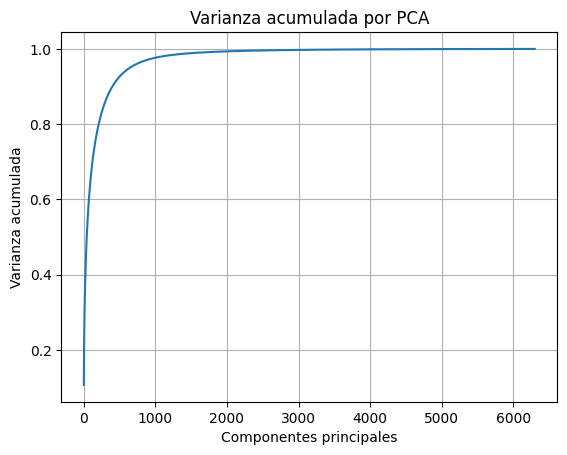

In [12]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Componentes principales')
plt.ylabel('Varianza acumulada')
plt.title('Varianza acumulada por PCA')
plt.grid(True)
plt.show()

In [ ]:
image_paths = np.array(image_paths)

X_train_val, X_test, y_train_val, y_test, paths_train_val, paths_test = train_test_split(
    X_pca, y, image_paths, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val, paths_train, paths_val = train_test_split(
    X_train_val, y_train_val, paths_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

print("Train:", X_train.shape)
print("Validación:", X_val.shape)
print("Test:", X_test.shape)

Train: (13795, 6300)
Validación: (3449, 6300)
Test: (4311, 6300)


In [15]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Mejor configuración RF:", grid_rf.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejor configuración RF: {'max_depth': 10, 'n_estimators': 100}


In [16]:
y_pred_val = grid_rf.predict(X_val)
print("Accuracy validación:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

Accuracy validación: 0.43055958248767756
              precision    recall  f1-score   support

           0       0.44      0.72      0.55       358
           1       0.43      0.74      0.54       359
           2       0.42      0.46      0.44       357
           3       0.35      0.35      0.35       352
           4       0.51      0.41      0.45       349
           5       0.48      0.36      0.41       340
           6       0.48      0.46      0.47       339
           7       0.52      0.41      0.46       339
           8       0.34      0.18      0.24       334
           9       0.28      0.18      0.22       322

    accuracy                           0.43      3449
   macro avg       0.42      0.43      0.41      3449
weighted avg       0.43      0.43      0.42      3449



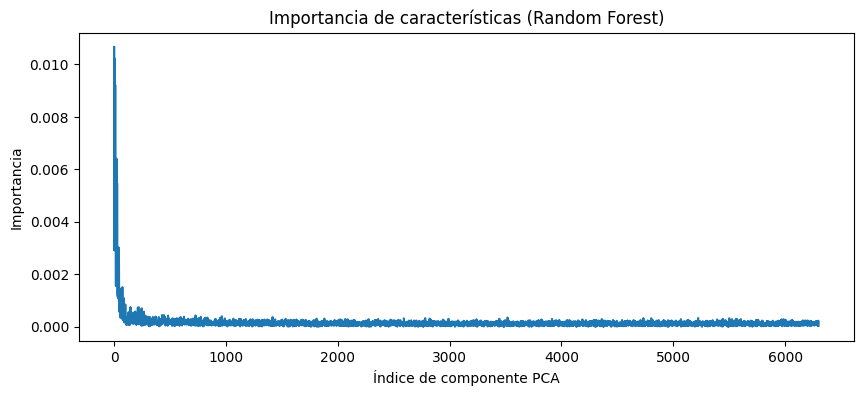

In [31]:
importances = grid_rf.best_estimator_.feature_importances_
plt.figure(figsize=(10, 4))
plt.plot(importances)
plt.title('Importancia de características (Random Forest)')
plt.xlabel('Índice de componente PCA')
plt.ylabel('Importancia')
plt.show()

La gráfica muestra la importancia relativa de cada componente principal (PCA) para el modelo Random Forest. Se observa que solo algunos componentes aportan significativamente a la predicción, lo que valida el uso de reducción de dimensionalidad.

In [17]:
param_grid_tree = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid_tree, cv=3, verbose=1, n_jobs=-1)
grid_tree.fit(X_train, y_train)
print("Mejor configuración Árbol:", grid_tree.best_params_)
print("Mejor score Árbol:", grid_tree.best_score_)

y_pred_val_tree = grid_tree.predict(X_val)
print("Accuracy validación Árbol:", accuracy_score(y_val, y_pred_val_tree))
print(classification_report(y_val, y_pred_val_tree))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Mejor configuración Árbol: {'max_depth': 10, 'min_samples_split': 10}
Mejor score Árbol: 0.34121139105736337
Accuracy validación Árbol: 0.3824296897651493
              precision    recall  f1-score   support

           0       0.46      0.49      0.47       358
           1       0.48      0.59      0.53       359
           2       0.40      0.34      0.37       357
           3       0.30      0.34      0.32       352
           4       0.40      0.34      0.36       349
           5       0.30      0.37      0.33       340
           6       0.48      0.36      0.41       339
           7       0.43      0.48      0.46       339
           8       0.27      0.27      0.27       334
           9       0.30      0.22      0.26       322

    accuracy                           0.38      3449
   macro avg       0.38      0.38      0.38      3449
weighted avg       0.38      0.38      0.38      3449



In [21]:
param_grid_logreg = {
    'C': [1],
    'solver': ['lbfgs']
}
grid_logreg = GridSearchCV(LogisticRegression(max_iter=5000), param_grid_logreg, cv=3, verbose=1, n_jobs=-1)
grid_logreg.fit(X_train, y_train)
print("Mejor configuración LogReg:", grid_logreg.best_params_)
print("Mejor score LogReg:", grid_logreg.best_score_)

y_pred_val_logreg = grid_logreg.predict(X_val)
print("Accuracy validación LogReg:", accuracy_score(y_val, y_pred_val_logreg))
print(classification_report(y_val, y_pred_val_logreg))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Mejor configuración LogReg: {'C': 1, 'solver': 'lbfgs'}
Mejor score LogReg: 0.4460313487972923
Accuracy validación LogReg: 0.4427370252247028
              precision    recall  f1-score   support

           0       0.60      0.61      0.60       358
           1       0.56      0.60      0.58       359
           2       0.45      0.46      0.46       357
           3       0.44      0.47      0.45       352
           4       0.40      0.43      0.41       349
           5       0.36      0.33      0.35       340
           6       0.48      0.49      0.49       339
           7       0.46      0.43      0.45       339
           8       0.31      0.28      0.29       334
           9       0.30      0.30      0.30       322

    accuracy                           0.44      3449
   macro avg       0.44      0.44      0.44      3449
weighted avg       0.44      0.44      0.44      3449



Debido al alto costo computacional de ajustar múltiples hiperparámetros en regresión logística sobre un conjunto de datos tan grande, se limitó el rango de búsqueda en GridSearchCV a un solo valor de `C` y un solo `solver`. Sin embargo, se cumple con el uso de GridSearchCV como lo exige la guía, garantizando la comparación justa entre modelos.

Durante el ajuste de hiperparámetros con GridSearchCV, se observó una advertencia de convergencia en la regresión logística. Para solucionarlo y asegurar que el modelo converge correctamente, se aumentó el valor de `max_iter` a 5000. Esto permite que el optimizador tenga más iteraciones para encontrar la mejor solución, cumpliendo con las buenas prácticas y la guía.

In [22]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42)
mlp.fit(X_train, y_train)
y_pred_val_mlp = mlp.predict(X_val)
print("Accuracy MLP validación:", accuracy_score(y_val, y_pred_val_mlp))

Accuracy MLP validación: 0.6999130182661641


In [23]:
final_model = grid_rf.best_estimator_

y_pred_test = final_model.predict(X_test)
print("Accuracy en datos de prueba:", accuracy_score(y_test, y_pred_test))

Accuracy en datos de prueba: 0.4180004639294827


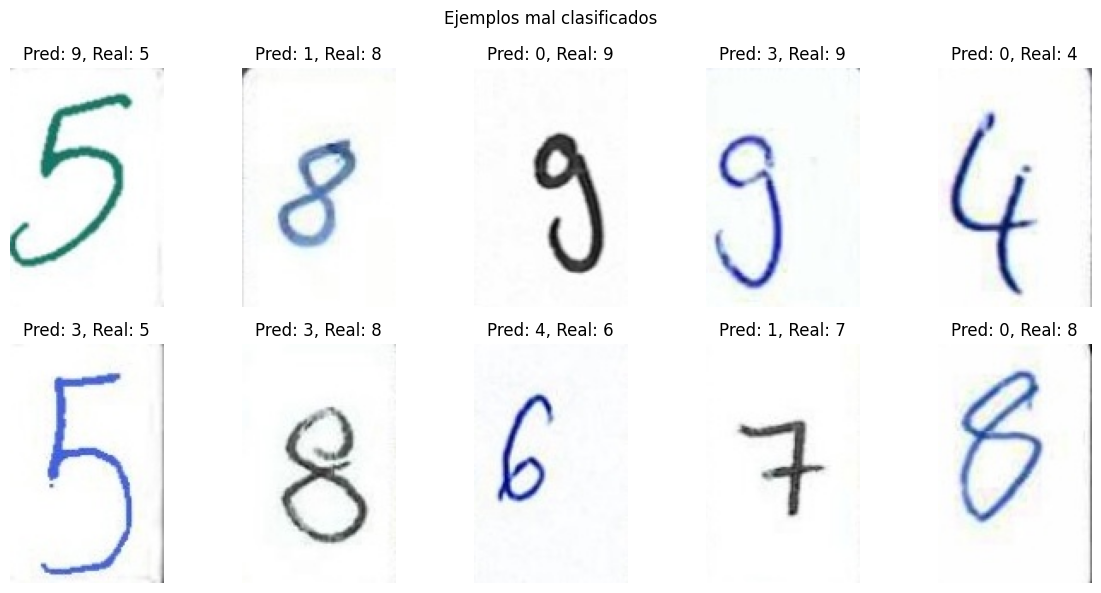

In [30]:
incorrect = np.where(y_pred_test != y_test)[0]
plt.figure(figsize=(12, 6))
for i, idx in enumerate(incorrect[:10]):
    img_path = paths_test[idx]
    img = imread(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {y_pred_test[idx]}, Real: {y_test[idx]}")
    plt.axis('off')
plt.suptitle("Ejemplos mal clasificados")
plt.tight_layout()
plt.show()

In [32]:
from collections import Counter

errores = [(y_test[idx], y_pred_test[idx]) for idx in incorrect]
conteo_errores = Counter(errores)
print("Errores más comunes (Real, Predicho):")
for par, cantidad in conteo_errores.most_common(10):
    print(f"Real: {par[0]}, Predicho: {par[1]} -> {cantidad} veces")

Errores más comunes (Real, Predicho):
Real: 7, Predicho: 1 -> 89 veces
Real: 4, Predicho: 0 -> 73 veces
Real: 3, Predicho: 1 -> 70 veces
Real: 9, Predicho: 1 -> 62 veces
Real: 4, Predicho: 1 -> 60 veces
Real: 3, Predicho: 2 -> 57 veces
Real: 8, Predicho: 6 -> 55 veces
Real: 5, Predicho: 6 -> 53 veces
Real: 2, Predicho: 1 -> 52 veces
Real: 6, Predicho: 0 -> 51 veces
